# Face recognition

## Packages importation

In [20]:
install.packages('imager')
install.packages('OpenImageR')
install.packages('ggplot2')
install.packages('reshape')
install.packages('cowplot')
library('cowplot')
library('ggplot2')
library('reshape')
library('OpenImageR')
library('imager')


The downloaded binary packages are in
	/var/folders/q6/rqx7by952vl927kfl2fslt5h0000gn/T//RtmpQHFm1M/downloaded_packages

The downloaded binary packages are in
	/var/folders/q6/rqx7by952vl927kfl2fslt5h0000gn/T//RtmpQHFm1M/downloaded_packages

  There is a binary version available but the source version is later:
        binary source needs_compilation
ggplot2  3.3.5  3.3.6             FALSE



installing the source package ‘ggplot2’





  There is a binary version available but the source version is later:
        binary source needs_compilation
reshape  0.8.8  0.8.9              TRUE



installing the source package ‘reshape’





The downloaded binary packages are in
	/var/folders/q6/rqx7by952vl927kfl2fslt5h0000gn/T//RtmpQHFm1M/downloaded_packages


Warning message:
“package ‘imager’ was built under R version 4.0.5”


ERROR: Error: package or namespace load failed for ‘imager’ in dyn.load(file, DLLpath = DLLpath, ...):
 impossible de charger l'objet partagé '/Library/Frameworks/R.framework/Versions/4.0/Resources/library/imager/libs/imager.so':
  dlopen(/Library/Frameworks/R.framework/Versions/4.0/Resources/library/imager/libs/imager.so, 6): Library not loaded: /opt/X11/lib/libX11.6.dylib
  Referenced from: /Library/Frameworks/R.framework/Versions/4.0/Resources/library/imager/libs/imager.so
  Reason: image not found


In [8]:
source("im2vect.R")

## Importing the images and creating the dataset

In [14]:
# Importing the images
D=NULL # matrix name BDD
for (k in 1:25){
  v = c(paste(k,"AT.jpg",sep=""),
      paste(k,"BT.jpg",sep=""),
      paste(k,"CT.jpg",sep=""),
      paste(k,"DT.jpg",sep=""),
      paste(k,"ET.jpg",sep=""),
      paste(k,"FT.jpg",sep=""))
  D = cbind(D,v)}

In [15]:
# Creating the dataset
n = dim(D) 
Data = NULL
for (j in 1:n[2]){ #across all people
  for (i in 1:(n[1])){ #across the images
    imacol = im2vect(D[i,j])
    Data = rbind(Data, imacol)
  }
}

In [16]:
# Adding the index to the data to be able to get the name of the picture
index=NULL
for (k in 1:ncol(D)){
  for (i in 1:nrow(D)){
    index = rbind(index, D[i,k])
  }
}
rownames(Data) = index

In [17]:
# Training set : 1 picture per person
Data_train = Data[-seq.int(1, nrow(Data), by=6),]

## Principal component analysis

In [18]:
# Getting the eigen values
n = dim(Data_train)
mu = mean(Data_train)
G = Data_train-mu

SigmaS = 1/(n[1]-1)*G%*%t(G)
eig = eigen(SigmaS) #calculing the eigen vectors and values of the small sigma
eigvect = t(G)%*%eig$vectors #calculing the eigen vectors and values of the big sigma

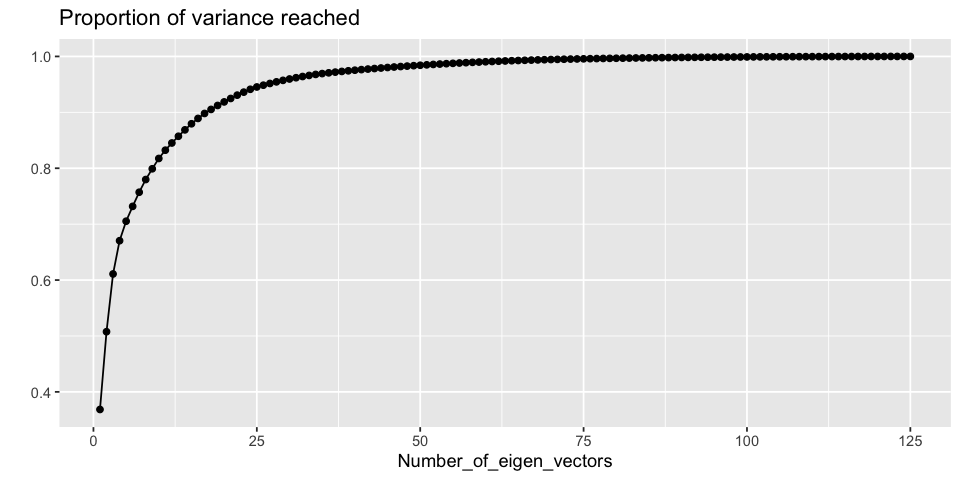

In [25]:
# Selecting the more important eigen vectors
prop = cumsum(eig$values)/sum(eig$values)
Number_of_eigen_vectors = 1:length(prop)

options(repr.plot.width=8, repr.plot.height=4)
ggplot(as.data.frame(prop),aes(x=Number_of_eigen_vectors , y=prop))+
  geom_line(stat = "identity")+geom_point()+labs(title = "Proportion of variance reached")+ ylab("")

N_PC = 33

In [26]:
# Creating the new training and validation data sets
Data_train.new = as.data.frame(Data_train%*%eigvect[,1:N_PC])

## Recognition

In [35]:
Recogn = function(photo, k){ # k the number of neighbors
  a = Sys.time()
  photo = im2vect(photo)
  values = photo%*%eigvect[,1:N_PC]

  dmatrix = dist(rbind(values,Data_train.new), method = "euclidean", diag = TRUE, upper = TRUE)
  dmatrix = as.matrix(dmatrix)
  dmatrix = dmatrix[1,2:(nrow(Data_train.new)+1)]

  ordenados = sort(dmatrix,index.return=TRUE,decreasing=FALSE)
  
  # Condition to spot someone we don't know
  # The minimum distance must be superior than a threshold (here set to 1800)
  if (ordenados$x[1]>1800){
    return(0)
  }
    
  num_sim = ordenados$ix[1:k]
  
  name_sim = data.frame(ordenados$x[1:k])
  k.nn = as.numeric(substr(rownames(name_sim),1,nchar(rownames(name_sim))-6))
  
  guess = as.numeric(rownames( data.frame( sort(table(k.nn), decreasing = T)[1] ) ))
  b = Sys.time()
  return(guess)
}

In [36]:
# Example
Recogn('1AT.jpg', 5)

[1] 1

In [37]:
#checking that the function works well on all the validation datas
for (k in 1:25){
  + print(Recogn(paste(k,'AT.jpg', sep=""),5))
}

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 24
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 0
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25


## Threshold optimization

In [53]:
data.plot = NULL
X = NULL
Y = NULL # Shortest distances of the pictures of the present people
Typo = NULL # {known ; unknow}

# Selecting the distance thresold of an unknown person : we plot the distances of known and unknown data
for (k in 1:25){
  # Taking out the k person to test the function with a new person
  Data_train = Data[-((k-1)*6+c(1:6)),]
  
  # Taking out the first image of each person to calculate the distance with a new image
  Data_train.new = Data_train[-seq.int(1, nrow(Data), by=6),]

  # With PCA
  n = dim(Data_train.new)
  mu = mean(Data_train.new)
  G = Data_train.new-mu
  SigmaS = 1/(n[1]-1)*G%*%t(G)
  eig = eigen(SigmaS) #calculing the eigen vectors and values of the small sigma
  eigvect = t(G)%*%eig$vectors #calculing the eigen vectors and values of the big sigma
  Data_train.proj = as.data.frame(Data_train.new%*%eigvect[,1:N_PC])
    
  #Data_train.proj = Data_train.new
  
  # Going through the first picture of every people (it got taken out of the training dataset)
  for (i in 1:25){ 
    photo = im2vect(index[6*(i-1)+1])
    values=photo%*%eigvect[, 1:N_PC]
    #values = photo
    
    dmatrix = dist(rbind(values, Data_train.proj), method = "euclidean", diag = TRUE, upper = TRUE)
    dmatrix = as.matrix(dmatrix)
    dmatrix = dmatrix[1, 2:(nrow(Data_train.proj)+1)]
    
    ordenados = sort(dmatrix,index.return=TRUE,decreasing=FALSE)
    Y = data.frame(rbind(Y, ordenados$x[1])) #getting the minimum distance of every picture for a given unknown
    
    
    if (i==k){ #split the output of the missing people from the rest to plot it differently
      Typo = rbind(Typo, c('unknown'))
    }else{
        Typo = rbind(Typo, c('known'))
    }
  }
  Typo = data.frame((Typo))
  
  Xk = data.frame(rep(k, 25))
  colnames(Xk) = c('X')
  X = data.frame(rbind(X, Xk))
 
  data.plotk = cbind(X,Y,Typo)
  colnames(data.plotk) = c('X','Y','Typo')
}

data.plot = rbind(data.plot, data.plotk)
colnames(data.plot) = c('X','Y','Typo')

data.plot=cbind(data.plot,Typo)
colnames(data.plot)=c('X','Y','Typo')

### Minimum distances calculated without PCA

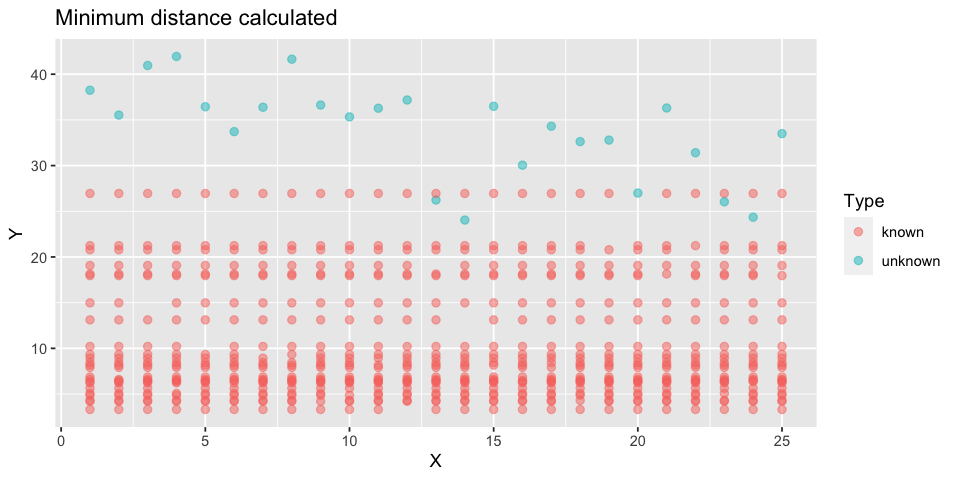

In [44]:
ggplot(data.plotk, aes(x=X, y=Y, color=Typo)) +
  geom_point(size=2, alpha=0.5)+labs(color="Type") +
  geom_abline(intercept = 1900, slope=0, size=0.5) +
  geom_text(x=12.5, y=2000, label="dist = 1900", color='black') +
  ggtitle('Minimum distance calculated')

We set the threshold depending on which error we want to avoid the most.  
Having no preference, we can set the threshold to 19.  
We then have 4/625=0,6% errors.

### Minimum distances calculated with PCA

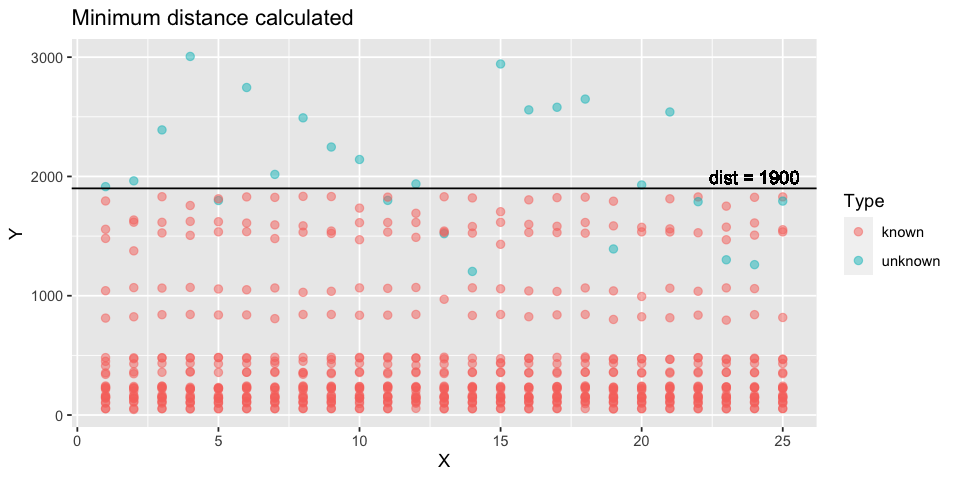

In [59]:
ggplot(data.plotk, aes(x=X, y=Y, color=Typo)) +
  geom_point(size=2, alpha=0.5)+labs(color="Type") +
  geom_abline(intercept = 1900, slope=0, size=0.5) +
  geom_text(x=24, y=2000, label="dist = 1900", color='black') +
  ggtitle('Minimum distance calculated')

In the same way, having no preference on the error, we can set the threshold to 1900 to reduce the number of errors to 8/625=1,3%.

# Conclusion

Computing the k-nn classifier with PCA is 10 times shorter than without.  
Even though the total time of 10 seconds can appear not that long, we are here using a very restrained database of only 150 images.  
Hence this factor is huge and using PCA can considerably improve the executing time.  
  
However the PCA lowers the performances down.  
  
Moreover, the threshold from which we identify the new picture as belonging to our dataset depends on the type of error we are more willing to do, and impacts the performances. 